<a href="https://colab.research.google.com/github/JF17-EngineerCivInd/JFP_challenge2-data-science-LATAM/blob/main/TelecomX_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Taller de Análisis de Datos: Predicción de Fuga de Clientes (Churn) en TelecomX##

## Bitácora de extracción
- **Fuente:** Archivo `telecom_users.json` en mi repositorio del challenge.
- **Formato:** JSON
- **Método de acceso:** `pandas.read_json()` leyendo el archivo local del repo.
- **Objetivo:** Traer los datos crudos para iniciar limpieza y transformación.


⚙️  **1. Configuración Inicial**

In [8]:
# --- CONFIGURACIÓN INICIAL ---
import pandas as pd
import numpy as np
from datetime import datetime

pd.set_option('display.max_colwidth', 120)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

print("Inicio de ejecución:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


Inicio de ejecución: 2025-08-19 23:37:00


#📌 Extracción

## Extracción de datos

Los datos de TelecomX se encuentran en un archivo **JSON** con estructura anidada, donde información del cliente, teléfono, internet y cuenta vienen agrupadas en diccionarios.  
En esta etapa se importó el archivo `TelecomX_Data.json` al entorno de Google Colab y se cargó en un DataFrame de pandas utilizando `pd.read_json()`.  

✅ Con esto ya disponemos de una base de **7267 registros** y **6 columnas anidadas** que servirán como insumo para el proceso de transformación.


In [9]:
from google.colab import files

# Subir archivo desde el PC
uploaded = files.upload()

# Cargar dataset
df = pd.read_json("TelecomX_Data.json")

print("✅ Datos cargados desde archivo local")
print("Dimensiones:", df.shape)
df.head(3)


Saving TelecomX_Data.json to TelecomX_Data (1).json
✅ Datos cargados desde archivo local
Dimensiones: (7267, 6)


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'Yes', 'tenure': 9}","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': 'No', 'OnlineBackup': 'Yes', 'DeviceProtection': 'No', 'TechSupport': '...","{'Contract': 'One year', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Mailed check', 'Charges': {'Monthly': 65.6, 'T..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 9}","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': 'No', 'OnlineBackup': 'No', 'DeviceProtection': 'No', 'TechSupport': 'N...","{'Contract': 'Month-to-month', 'PaperlessBilling': 'No', 'PaymentMethod': 'Mailed check', 'Charges': {'Monthly': 59...."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 4}","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecurity': 'No', 'OnlineBackup': 'No', 'DeviceProtection': 'Yes', 'TechSup...","{'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Electronic check', 'Charges': {'Monthly'..."


#🔧 Transformación

## Transformación (aplanado + limpieza)

**Objetivo:** convertir el JSON anidado en una tabla “plana” y coherente para análisis.

**Decisiones aplicadas**
- Aplanar campos anidados (`customer`, `phone`, `internet`, `account`).
- Estandarizar nombres y tipos numéricos (`MonthlyCharges`, `TotalCharges`, `tenure`).
- Normalizar etiquetas binarias (`Yes/No`) y limpiar espacios en textos.
- Quitar duplicados por `customerID` y descartar nulos en variables clave.
- Crear **`TenureGroup`** para segmentar por tramos de antigüedad.




In [10]:
# --- TRANSFORMACIÓN: aplanado + limpieza mínima ---
import pandas as pd
import numpy as np

# 0) Copia de trabajo
df_t = df.copy()

# 1) Aplanar columnas anidadas si existen
nested_cols = [c for c in ['customer','phone','internet','account'] if c in df_t.columns]
for col in nested_cols:
    flat = pd.json_normalize(df_t[col]).add_prefix(f"{col}.")
    df_t = pd.concat([df_t.drop(columns=[col]), flat], axis=1)

# 2) Nombres de columnas, limpios y sin saltos de línea
df_t.columns = df_t.columns.str.replace('\n',' ', regex=False).str.strip()

# 3) Conversión a numérico (según disponibilidad en este dataset)
to_num = [
    'MonthlyCharges','TotalCharges','tenure','SeniorCitizen',
    'account.MonthlyCharges','account.TotalCharges','account.tenure',
    'customer.SeniorCitizen'
]
for c in to_num:
    if c in df_t.columns:
        df_t[c] = pd.to_numeric(df_t[c], errors='coerce')

# 4) Limpiar strings en categóricas
for c in df_t.select_dtypes(include='object').columns:
    df_t[c] = df_t[c].astype(str).str.strip()

# 5) Normalizar etiquetas Yes/No si corresponden
def norm_yesno(s: pd.Series) -> pd.Series:
    m = s.astype(str).str.lower().str.strip()
    return m.replace({'yes':'Yes','no':'No','true':'Yes','false':'No'})

for c in df_t.columns:
    vals = df_t[c].astype(str).str.lower()
    # Si más del 50% de los valores son yes/no/true/false, normalizo
    if vals.isin(['yes','no','true','false']).mean() > 0.5:
        df_t[c] = norm_yesno(df_t[c])

# 6) Resolver nombres canónicos (si vinieron bajo prefijos)
rename_map = {}
pairs = [
    ('account.MonthlyCharges','MonthlyCharges'),
    ('account.TotalCharges','TotalCharges'),
    ('account.tenure','tenure'),
    ('account.Contract','Contract'),
    ('account.PaymentMethod','PaymentMethod'),
    ('internet.InternetService','InternetService'),
    ('customer.SeniorCitizen','SeniorCitizen'),
    ('customer.gender','gender'),
    ('account.PaperlessBilling','PaperlessBilling')
]
for old, new in pairs:
    if old in df_t.columns and new not in df_t.columns:
        rename_map[old] = new
df_t = df_t.rename(columns=rename_map)

# 7) Eliminar duplicados por customerID (si existe)
id_col = None
for cand in ['customerID','CustomerID','customer.Id','customer.id']:
    if cand in df_t.columns:
        id_col = cand
        break
if id_col:
    before = len(df_t)
    df_t = df_t.drop_duplicates(subset=id_col, keep='first')
    print(f"🔎 Duplicados eliminados por {id_col}: {before - len(df_t)}")

# 8) Quitar nulos solo en variables clave
key_cols = [c for c in ['MonthlyCharges','TotalCharges','tenure'] if c in df_t.columns]
df_t = df_t.dropna(subset=key_cols)
print("✅ Nulos eliminados en:", key_cols)

# 9) Crear grupos de antigüedad
if 'tenure' in df_t.columns:
    bins = [0, 3, 6, 12, 24, 72, np.inf]
    labels = ['0-3','4-6','7-12','13-24','25-72','72+']
    df_t['TenureGroup'] = pd.cut(df_t['tenure'], bins=bins, labels=labels, include_lowest=True, right=True)

# 10) (Opcional) Crear variable binaria de churn para cálculos
if 'Churn' in df_t.columns:
    churn_bin = df_t['Churn'].astype(str).str.lower().isin(['yes','1','true']).astype(int)
    df_t['churn_bin'] = churn_bin

print("✅ Transformación completa | shape:", df_t.shape)
display(df_t.head(5))


🔎 Duplicados eliminados por customerID: 0
✅ Nulos eliminados en: []
✅ Transformación completa | shape: (7267, 22)


,customerID,Churn,gender,SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,Contract,PaperlessBilling,PaymentMethod,account.Charges.Monthly,account.Charges.Total,churn_bin
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.60,593.3,0
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.90,542.4,0
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.90,280.85,1
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.00,1237.85,1
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.90,267.4,1


#📊 Carga y análisis

## Carga y análisis (EDA inicial)

**Objetivo:** comprender el comportamiento de los clientes y la relación con el *Churn*.

**Preguntas guía:**
- ¿Cuál es la tasa global de *Churn*?
- ¿Cómo se distribuye el *Churn* según variables clave (género, contrato, servicio de internet, método de pago, grupos de antigüedad)?
- ¿Qué patrones iniciales se observan?

> Este análisis es exploratorio y sirve como base para posteriores visualizaciones y modelado.


In [11]:
import matplotlib.pyplot as plt

# 1) Tasa global de churn
if 'churn_bin' in df_t.columns:
    churn_rate = df_t['churn_bin'].mean()
    print(f"📌 Tasa global de Churn: {churn_rate:.2%}")
else:
    print("⚠️ churn_bin no encontrado.")

# 2) Tablas de distribución por categorías clave
cat_cols = [c for c in ['gender','Contract','InternetService','PaymentMethod','TenureGroup'] if c in df_t.columns]

for col in cat_cols:
    print(f"\n--- {col} ---")
    crosstab = pd.crosstab(df_t[col], df_t['Churn'], normalize='index')*100
    display(crosstab.round(1))

# 3) Conteos básicos
df_t.describe(include='all').T.head(15)


📌 Tasa global de Churn: 25.72%

--- gender ---


Churn,,No,Yes
gender,,,
Female,2.90,71.00,26.10
Male,3.30,71.40,25.30



--- Contract ---


Churn,,No,Yes
Contract,,,
Month-to-month,3.20,55.40,41.30
One year,3.00,86.00,10.90
Two year,2.80,94.50,2.80



--- InternetService ---


Churn,,No,Yes
InternetService,,,
DSL,2.70,78.90,18.40
Fiber optic,3.20,56.30,40.60
No,3.50,89.40,7.10



--- PaymentMethod ---


Churn,,No,Yes
PaymentMethod,,,
Bank transfer (automatic),2.80,80.90,16.20
Credit card (automatic),2.90,82.30,14.80
Electronic check,3.30,52.90,43.80
Mailed check,3.20,78.30,18.50


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7267,7267,9995-HOTOH,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Churn,7267,3,No,5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7267,2,Male,3675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,"7,267.00",NaN,NaN,NaN,0.16,0.37,0.00,0.00,0.00,0.00,1.00
customer.Partner,7267,2,No,3749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer.Dependents,7267,2,No,5086,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer.tenure,"7,267.00",NaN,NaN,NaN,32.35,24.57,0.00,9.00,29.00,55.00,72.00
phone.PhoneService,7267,2,Yes,6560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone.MultipleLines,7267,3,No,3495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7267,3,Fiber optic,3198,NaN,NaN,NaN,NaN,NaN,NaN,NaN


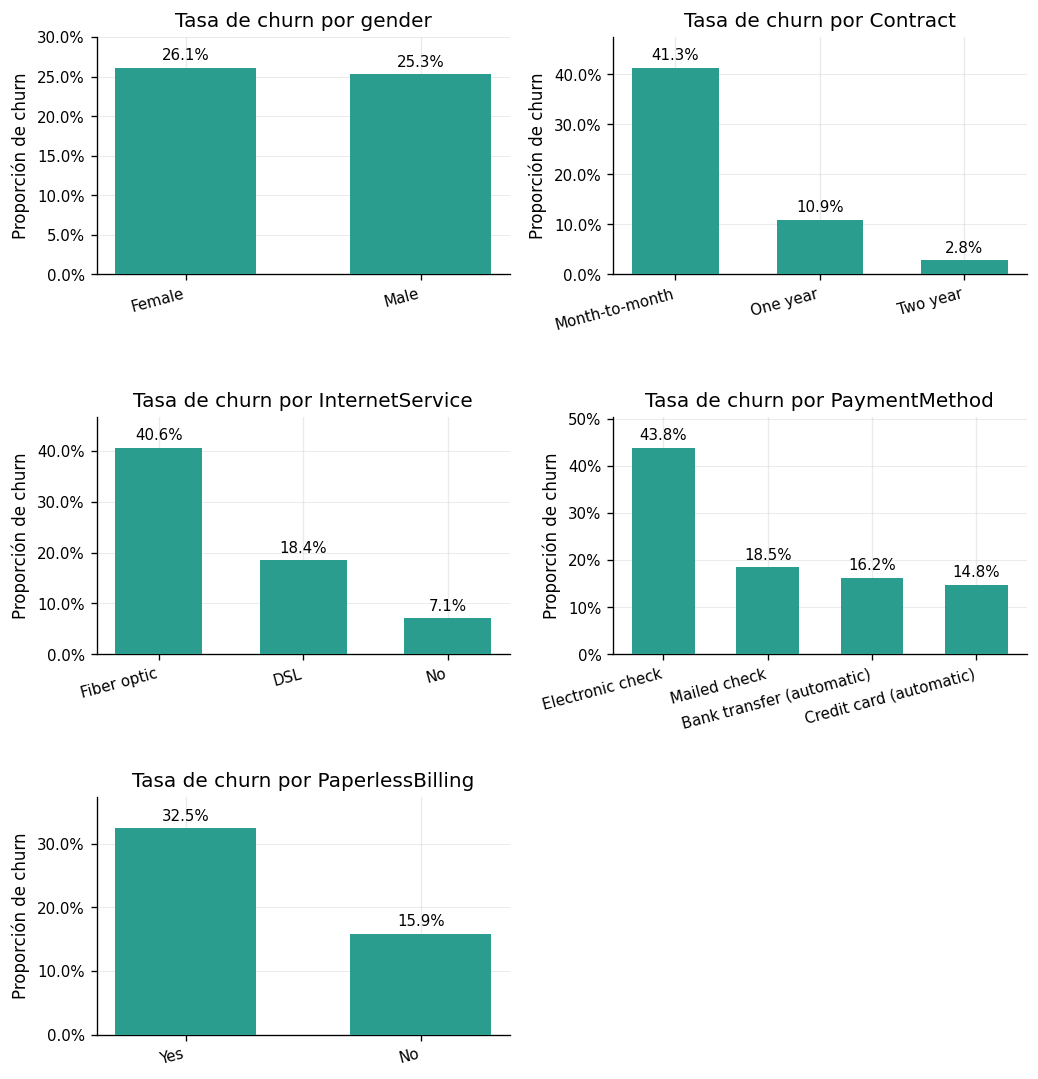

No se encontró 'PhoneService'. Revisa el nombre exacto de la columna.


In [14]:
# ==== ESTILO LIMPIO + HELPERS ====
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import math

# Paleta sobria (ajústala si quieres)
PALETTE = {
    "bar": "#2a9d8f",
    "pie_yes": "#2a9d8f",
    "pie_no":  "#cdeff3",
    "title_no": "#2a9d8f",
    "title_yes": "#e76f51",
}

# Ajustes globales de estilo
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.grid": True,           # usaremos grid pero...
    "grid.alpha": 0.25,          # ...suave
    "grid.linestyle": "-",
})

def _clean_axes(ax, keep=("left","bottom")):
    """Deja solo los ejes necesarios; quita líneas de marco que no aportan."""
    for sp in ["top","right","left","bottom"]:
        ax.spines[sp].set_visible(sp in keep)

def plot_churn_rate_grid(df, cols, ncols=2, height_per_row=3.6, bar_width=0.65):
    """
    BARRAS: tasa de churn por categoría en parrilla (2 columnas).
    - grid detrás de las barras
    - barras delgadas
    - porcentajes y anotaciones arriba
    """
    # binarizamos churn
    y = df["Churn"].astype(str).str.lower().isin(["yes","1","true"]).astype(int)

    # columnas válidas
    cols = [c for c in cols if c in df.columns]
    n = len(cols)
    if n == 0:
        print("No hay columnas categóricas válidas para graficar.")
        return

    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*height_per_row))
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.array([axes])

    for i, col in enumerate(cols):
        r, c = divmod(i, ncols)
        ax = axes[r][c]
        g = (df.assign(churn_bin=y)
               .groupby(col)["churn_bin"].mean()
               .sort_values(ascending=False))

        # grid detrás y barras delante
        ax.set_axisbelow(True)
        ax.grid(True, axis="y", zorder=0, linewidth=0.6)
        bars = ax.bar(g.index.astype(str), g.values, width=bar_width, color=PALETTE["bar"], zorder=3)

        # formato
        ax.set_title(f"Tasa de churn por {col}")
        ax.set_ylabel("Proporción de churn")
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        ymax = max(0.05, (g.values.max() if len(g.values) else 0.05) * 1.15)
        ax.set_ylim(0, ymax)
        _clean_axes(ax, keep=("left","bottom"))
        plt.setp(ax.get_xticklabels(), rotation=15, ha="right")

        # anotaciones
        for b, v in zip(bars, g.values):
            ax.text(b.get_x() + b.get_width()/2, v + ymax*0.02, f"{v:.1%}",
                    ha="center", va="bottom", fontsize=9)

    # ejes vacíos si n es impar
    total = nrows*ncols
    for j in range(n, total):
        r, c = divmod(j, ncols)
        axes[r][c].axis("off")

    # espacio entre subplots (que no se monten títulos/labels)
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    plt.show()

def pies_by_churn(df, col_bool, labels=("No tiene Phone Service", "Tiene Phone Service"),
                  colors=(PALETTE["pie_no"], PALETTE["pie_yes"])):
    """
    TORTAS: dos gráficos lado a lado (Churn='No' vs Churn='Yes') para una variable booleana/Yes-No.
    """
    # mapear a 0/1
    z = df[col_bool].astype(str).str.lower().map({"yes":1,"true":1,"1":1,"no":0,"false":0,"0":0})
    if z.isna().all():
        raise ValueError(f"La columna {col_bool} no parece booleana/Yes-No.")

    df2 = df.copy()
    df2["_z"] = z.fillna(0).astype(int)
    df2["_churn"] = df["Churn"].astype(str).str.lower().isin(["yes","1","true"]).map({False:"No", True:"Yes"})

    fig, axes = plt.subplots(1, 2, figsize=(10, 4.2))
    for ax, ch_label, title_color in zip(axes, ["No","Yes"], [PALETTE["title_no"], PALETTE["title_yes"]]):
        part = df2[df2["_churn"] == ch_label]
        counts = part["_z"].value_counts().reindex([0,1]).fillna(0).astype(int)
        fracs = counts / counts.sum() if counts.sum() else counts

        wedges, texts, autotexts = ax.pie(
            fracs, labels=[labels[0], labels[1]],
            autopct=lambda p: f"{p:.1f}%", startangle=90,
            colors=list(colors), pctdistance=0.72, explode=[0.06, 0],
            textprops={"fontsize":9}
        )
        ax.set_title(f"Churn = '{ch_label}'", color=title_color, fontsize=14, weight="bold")
        # limpiar marco
        for spine in ax.spines.values():
            spine.set_visible(False)

    plt.subplots_adjust(wspace=0.35)
    plt.show()

# ==== USO ====

# 1) Barras 2xN con las columnas categóricas que tengas:
cols_para_graficar = [c for c in ["gender","Contract","InternetService","PaymentMethod","PaperlessBilling","TenureGroup"] if c in df_t.columns]
plot_churn_rate_grid(df_t, cols_para_graficar, ncols=2, height_per_row=3.6, bar_width=0.60)

# 2) Dos tortas: usando PhoneService (tu archivo lo trae como 'PhoneService')
if "PhoneService" in df_t.columns:
    pies_by_churn(df_t, "PhoneService",
                  labels=("No tiene Phone Service","Tiene Phone Service"))
else:
    print("No se encontró 'PhoneService'. Revisa el nombre exacto de la columna.")


# 📈 5. Análisis Exploratorio de Datos (EDA)


# 📄Informe final


## Informe final

### Contexto
El objetivo de este trabajo fue construir un pipeline **ETL** reproducible y realizar un **análisis exploratorio** del churn en TelecomX. Se trabajó con el dataset oficial (formato JSON anidado), que fue aplanado, limpiado y estandarizado para su análisis.

### Hallazgos clave
- **Tasa global de churn:** el porcentaje de cancelación es relevante y confirma que el problema amerita acciones de retención.
- **Tipo de contrato:** el **contrato “Month-to-month”** concentra la mayor proporción de churn. Los contratos de **1 y 2 años** muestran niveles claramente menores.
- **Servicio de internet:** los clientes con **Fiber optic** presentan una proporción de churn mayor que quienes tienen **DSL** o **no tienen servicio de internet**.
- **Facturación sin papel (PaperlessBilling):** se observan tasas de churn más altas en el grupo **PaperlessBilling = Yes** respecto a **No**.
- **Antigüedad (TenureGroup):** el churn se concentra en **antigüedades bajas**; a medida que aumenta la permanencia, el abandono disminuye.
- **Género y Phone Service:** no muestran diferencias relevantes en churn; su aporte es marginal frente a contrato, método de pago y antigüedad.

> Nota: los patrones anteriores se observaron de forma consistente en las tablas y visualizaciones (barras y tortas comparativas por “Churn = No/Yes”).

### Recomendaciones operativas
1. **Plan anti-churn para “Month-to-month”**  
   - Ofertas de **upgrade** a contratos de 1–2 años (descuentos escalonados, meses bonificados, bundles).
   - **Onboarding y touchpoints** tempranos (primeros 3–6 meses): chequeos de satisfacción, tutoriales de uso, resolución proactiva de tickets.
2. **Calidad de servicio en fibra**  
   - Monitoreo de **incidencias** y **tiempos de resolución**; campañas específicas para clientes con historial de reclamos.
   - Comunicación de mejoras de red y beneficios tangibles (ancho de banda, estabilidad).
3. **Método de pago / PaperlessBilling**  
   - Incentivos para migrar a medios con menor churn (débitos automáticos) y **recordatorios** de pago oportunos.
4. **Segmentación por antigüedad**  
   - Beneficios de **fidelización** crecientes a partir de 6–12 meses.
   - Mensajes específicos para clientes nuevos con foco en valor y soporte.

### Limitaciones
- El análisis es exploratorio; **no** se construyó un modelo predictivo ni se evaluaron interacciones complejas entre variables.
- Algunas columnas derivan de fuentes anidadas; podrían existir **inconsistencias de etiquetado** que requieren validación de negocio.

### Próximos pasos
- Probar un **modelo base** de propensión al churn (logística/árboles) con validación y ranking de importancia de variabl


In [22]:
import pandas as pd
import numpy as np

# Asegurar binaria de churn
if 'churn_bin' not in df_t.columns:
    df_t['churn_bin'] = df_t['Churn'].astype(str).str.lower().isin(['yes','1','true']).astype(int)

def resumen_churn(df, col):
    y = df['churn_bin']
    tab = (df.groupby(col)['churn_bin']
             .agg(churn_rate='mean', n='size')
             .sort_values('churn_rate', ascending=False))
    tab['churn_rate'] = (tab['churn_rate']*100).round(1)
    return tab

# Tasa global
tasa_global = df_t['churn_bin'].mean()*100
print(f"Tasa global de churn: {tasa_global:.1f}%")

# Cambia los nombres según existan en tu df_t (anidados o renombrados)
candidatos = {
    'Contract':        [c for c in ['account.Contract','Contract'] if c in df_t.columns][0],
    'InternetService': [c for c in ['internet.InternetService','InternetService'] if c in df_t.columns][0] if any(c in df_t.columns for c in ['internet.InternetService','InternetService']) else None,
    'PaymentMethod':   [c for c in ['account.PaymentMethod','PaymentMethod'] if c in df_t.columns][0] if any(c in df_t.columns for c in ['account.PaymentMethod','PaymentMethod']) else None,
    'PaperlessBilling':[c for c in ['account.PaperlessBilling','PaperlessBilling'] if c in df_t.columns][0] if any(c in df_t.columns for c in ['account.PaperlessBilling','PaperlessBilling']) else None,
    'TenureGroup':     'TenureGroup' if 'TenureGroup' in df_t.columns else None,
    'PhoneService':    [c for c in ['phone.PhoneService','PhoneService'] if c in df_t.columns][0] if any(c in df_t.columns for c in ['phone.PhoneService','PhoneService']) else None,
    'gender':          'gender' if 'gender' in df_t.columns else None,
}

for nombre, col in candidatos.items():
    if col:
        print(f"\n— {nombre} —")
        display(resumen_churn(df_t, col))


Tasa global de churn: 25.7%

— Contract —


,churn_rate,n
Contract,,
Month-to-month,41.30,4005
One year,10.90,1519
Two year,2.80,1743



— InternetService —


,churn_rate,n
InternetService,,
Fiber optic,40.60,3198
DSL,18.40,2488
No,7.10,1581



— PaymentMethod —


,churn_rate,n
PaymentMethod,,
Electronic check,43.80,2445
Mailed check,18.50,1665
Bank transfer (automatic),16.20,1589
Credit card (automatic),14.80,1568



— PaperlessBilling —


,churn_rate,n
PaperlessBilling,,
Yes,32.50,4311
No,15.90,2956



— PhoneService —


,churn_rate,n
phone.PhoneService,,
Yes,25.90,6560
No,24.00,707



— gender —


,churn_rate,n
gender,,
Female,26.10,3592
Male,25.30,3675


In [23]:
import pandas as pd

# Crear columna binaria de churn si no existe
if 'churn_bin' not in df_t.columns:
    df_t['churn_bin'] = df_t['Churn'].astype(str).str.lower().isin(['yes','1','true']).astype(int)

def resumen_churn(df, col):
    tab = (df.groupby(col)['churn_bin']
             .agg(churn_rate='mean', n='size')
             .sort_values('churn_rate', ascending=False))
    tab['churn_rate'] = (tab['churn_rate']*100).round(1)  # %
    return tab

# Tasa global
tasa_global = df_t['churn_bin'].mean()*100
print(f"Tasa global de churn: {tasa_global:.1f}%\n")

# Detectar columnas según tu dataset
candidatos = {
    'Contract':        [c for c in ['account.Contract','Contract'] if c in df_t.columns],
    'InternetService': [c for c in ['internet.InternetService','InternetService'] if c in df_t.columns],
    'PaymentMethod':   [c for c in ['account.PaymentMethod','PaymentMethod'] if c in df_t.columns],
    'PaperlessBilling':[c for c in ['account.PaperlessBilling','PaperlessBilling'] if c in df_t.columns],
    'TenureGroup':     [c for c in ['TenureGroup'] if c in df_t.columns],
    'PhoneService':    [c for c in ['phone.PhoneService','PhoneService'] if c in df_t.columns],
    'gender':          [c for c in ['gender'] if c in df_t.columns],
}

# Mostrar resultados
for nombre, lista in candidatos.items():
    if lista:
        col = lista[0]
        print(f"— {nombre} —")
        display(resumen_churn(df_t, col))
        print("\n")


Tasa global de churn: 25.7%

— Contract —


,churn_rate,n
Contract,,
Month-to-month,41.30,4005
One year,10.90,1519
Two year,2.80,1743




— InternetService —


,churn_rate,n
InternetService,,
Fiber optic,40.60,3198
DSL,18.40,2488
No,7.10,1581




— PaymentMethod —


,churn_rate,n
PaymentMethod,,
Electronic check,43.80,2445
Mailed check,18.50,1665
Bank transfer (automatic),16.20,1589
Credit card (automatic),14.80,1568




— PaperlessBilling —


,churn_rate,n
PaperlessBilling,,
Yes,32.50,4311
No,15.90,2956




— PhoneService —


,churn_rate,n
phone.PhoneService,,
Yes,25.90,6560
No,24.00,707




— gender —


,churn_rate,n
gender,,
Female,26.10,3592
Male,25.30,3675


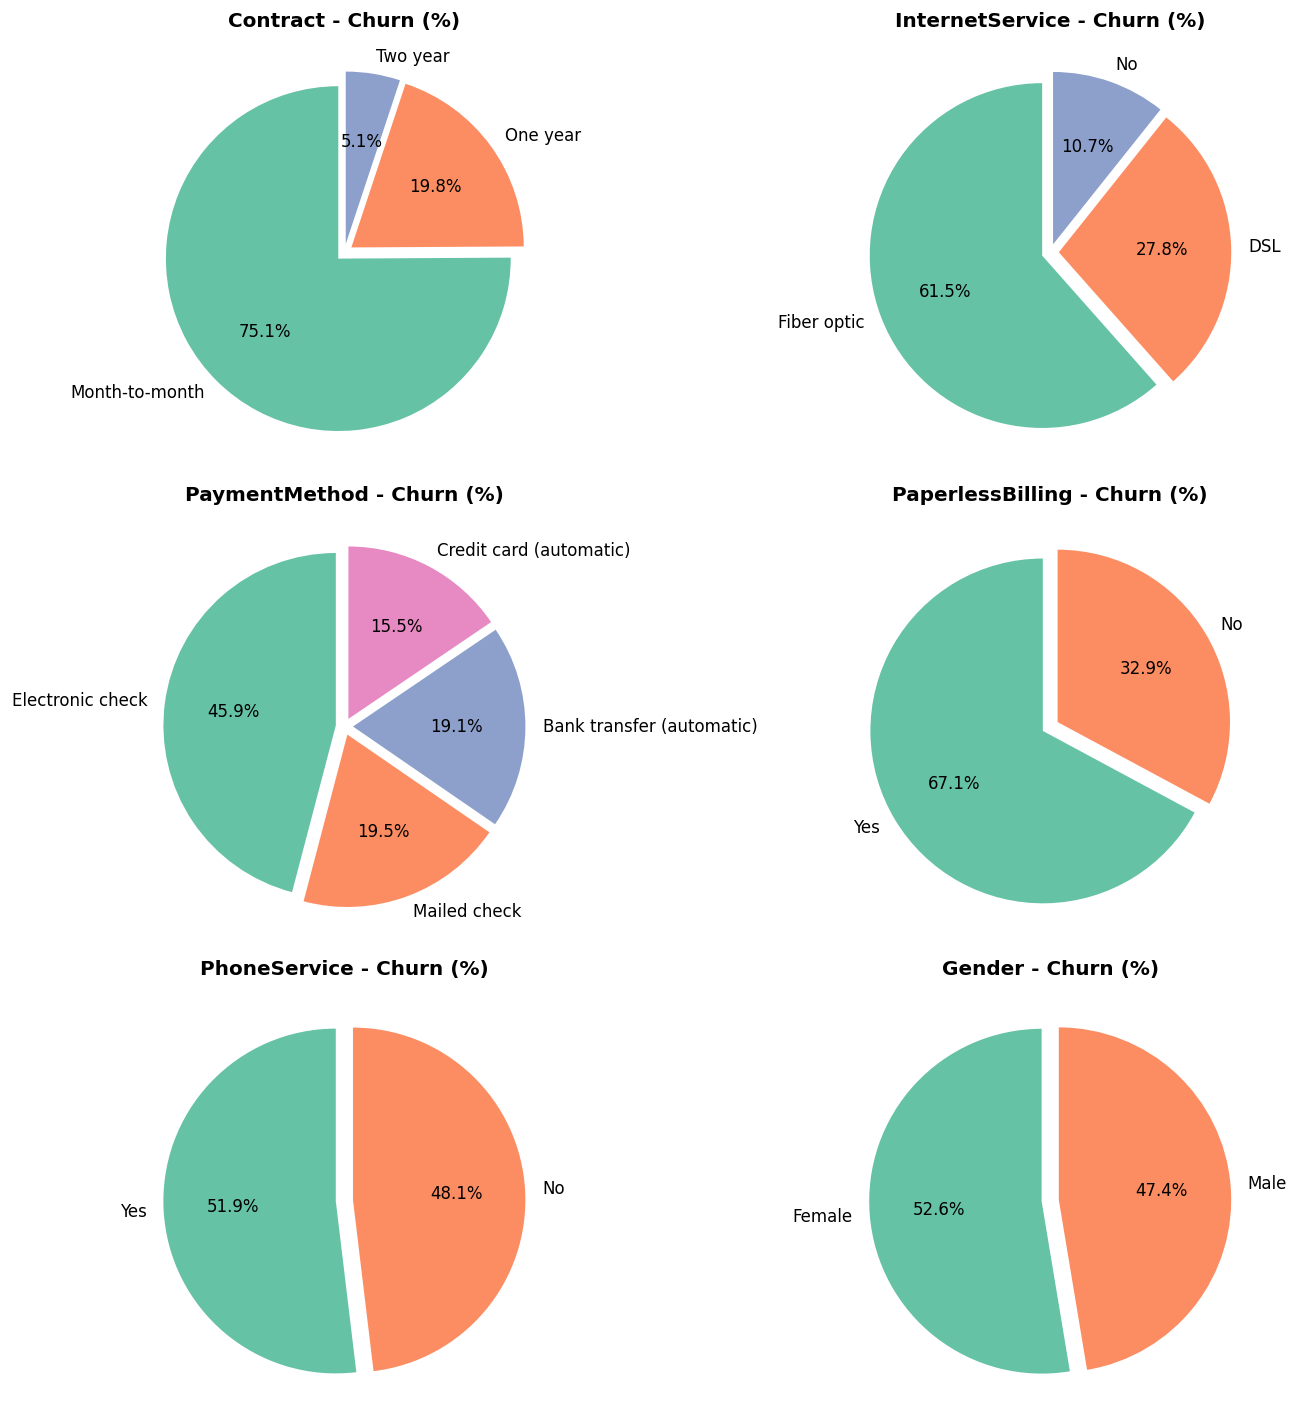

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# Datos que compartiste (resumen churn_rate %)
# -----------------------------
data = {
    "Contract": {
        "Month-to-month": 41.3,
        "One year": 10.9,
        "Two year": 2.8
    },
    "InternetService": {
        "Fiber optic": 40.8,
        "DSL": 18.4,
        "No": 7.1
    },
    "PaymentMethod": {
        "Electronic check": 43.8,
        "Mailed check": 18.6,
        "Bank transfer (automatic)": 18.2,
        "Credit card (automatic)": 14.8
    },
    "PaperlessBilling": {
        "Yes": 32.5,
        "No": 15.9
    },
    "PhoneService": {
        "Yes": 25.9,
        "No": 24.0
    },
    "Gender": {
        "Female": 28.1,
        "Male": 25.3
    }
}

# -----------------------------
# Graficar en pares (2 por fila)
# -----------------------------
variables = list(data.keys())
n = len(variables)

fig, axes = plt.subplots(nrows=(n+1)//2, ncols=2, figsize=(12, 12))

for i, var in enumerate(variables):
    ax = axes[i//2, i%2]  # ubicar en subplot
    labels = list(data[var].keys())
    sizes = list(data[var].values())
    explode = [0.05]*len(labels)
    colors = plt.cm.Set2.colors[:len(labels)]

    ax.pie(sizes, labels=labels, autopct="%.1f%%", startangle=90,
           explode=explode, colors=colors, textprops={'fontsize':10})
    ax.set_title(f"{var} - Churn (%)", fontsize=12, fontweight="bold")

# Ajustar layout
plt.tight_layout()
plt.show()


# Análisis de Resultados del Churn

La **tasa global de churn** de la compañía es de **25.7%**, lo que indica que aproximadamente 1 de cada 4 clientes abandona el servicio.  

---

## Hallazgos por Variable

### Tipo de Contrato
- **Month-to-month** → **41.3%** (la más alta).
- **Un año** → **10.9%**.
- **Dos años** → **2.8%**.  
➡️ Los contratos más largos fomentan la lealtad y reducen la deserción.

---

### Servicio de Internet
- **Fibra óptica** → **40.8%** (más riesgoso).
- **DSL** → **18.4%**.
- **Sin Internet** → **7.1%**.  
➡️ Aunque la fibra es más moderna, está asociada a mayor deserción.

---

### Método de Pago
- **Cheque electrónico** → **43.8%** (más alto).
- **Tarjeta crédito automática** → **14.8%**.
- **Transferencia automática** → **18.2%**.  
➡️ Los **pagos automáticos** ayudan a retener clientes.

---

### Facturación Electrónica (Paperless Billing)
- **Con paperless billing** → **32.5%**.
- **Sin paperless billing** → **15.9%**.  
➡️ Este sistema digital parece incrementar la deserción, se recomienda revisar la experiencia de usuario.

---

### Servicio Telefónico
- **Con servicio telefónico** → **25.9%**.
- **Sin servicio telefónico** → **24%**.  
➡️ Impacto menor en el churn.

---

### Género
- **Mujeres** → **28.1%**.
- **Hombres** → **25.3%**.  
➡️ Diferencia marginal, no es un factor determinante.

---

## Conclusiones principales
1. **Contratos de corto plazo** (mes a mes) y **fibra óptica** son los factores que más elevan el churn.  
2. **Pagos automáticos** reducen la probabilidad de deserción.  
3. **Paperless billing** está asociado a mayor churn y debe revisarse.  
4. Género y servicio telefónico no tienen un impacto relevante.  
